### Tryout model Pytorch

In [1]:
#!pip install pytorch-ignite
#!pip install -e /workspace/VisionWorks

#!nvidia-smi               #shell ?
#!nvcc --version           #shell ?#
#!pip install tqdm
#!pip install sklearn
#!pip install wandb --upgrade

In [2]:
import wandb
from ignite.contrib.handlers.wandb_logger import *
from ignite.contrib.engines.common import * # does contain the setup_wandb_logging
import os

import ignite
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix 
from ignite.handlers import ModelCheckpoint, EarlyStopping

from PIL import Image
from read_lapchol import LapcholDataset
from matplotlib.pyplot import imshow
#from transforms import ReadPILImage
import torch
from torch.optim import Adam
from torchvision.models import resnet18
from torchvision.models import resnet50
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np

import random

import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import sklearn
from sklearn.model_selection import KFold

from visionworks.transformation.loading.image_loading import LoadPILImage
from visionworks.transformation.image.image_transforms import ResizePILImage, ResizeNumpyImage, CenterCropTorchvision, ResizeTorchvision 
from visionworks.transformation import TorchvisionTformWrapper

from torchvision import transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor

from transforms import LabelToInt, LabelToTensor, DicttoImageandLabel 



In [3]:
wandb.login()
#!wandb login <13a1f666958082496c4b39a10519f6db055b76d3>
#!wandb login --relogin


wandb: Currently logged in as: jnjsurgery (use `wandb login --relogin` to force relogin)


True

In [4]:
wandb.init(project='project1', 
        entity='rubyegging',
    name="classify_difficulty",
    config={  
        "learning_rate": 0.0001,
        "epochs": 5,
        "batch_size": 32,
        "classes": 2,
        "loss_function": "BCELoss",
        "optimizer": "Adam",
        "architecture": "Resnet50",
        "dataset": "Lapchol_dataset"},
    tags=["pytorch-ignite", "lapchol", "first_run"]
)

config = wandb.config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class_labels = [1,2]

# hyperparameters in config.  

# define transform
tform = Compose([LoadPILImage(fields=['frame_path']),ResizePILImage(fields=['frame_path'], width=256, height=256), 
                 CenterCropTorchvision(fields=['frame_path'], width=224, height=224),
                 TorchvisionTformWrapper(fields=['frame_path'], transform=ToTensor()), 
                 LabelToInt(fields=['label'], labels=class_labels), LabelToTensor(fields=['label']), 
                 TorchvisionTformWrapper(fields=['frame_path'],transform=transforms.Normalize(mean=[0.355,0.258,0.238], std=[0.250, 0.192, 0.175])),
                 DicttoImageandLabel(image=['frame_path'], label=['label']) ])   
                 #])  DicttoImageandLabel(image=['frame_path'], label=['label']) ]) 

# Load lapchol dataset
print('The train set:')
lapchol_train = LapcholDataset(root_dir='/workspace/Lapchol_dataset', incl_videos=[88,89,92,94,95,97,98,102,103,105,106,107,109,110,111,113,115,118,119,120,125,127,139,144,150,152,156,160,172,180,189,205,214,215,220,224,226,227,228,336,348,351], sample_rate=1,transform=tform) #70% # 
print('Number of samples in train set:' + str(lapchol_train.__len__()))

print('The validation set:')
lapchol_val = LapcholDataset(root_dir='/workspace/Lapchol_dataset', incl_videos=[242,251,286,289,292,301,302,304,309,310,315,316,358,360,367,373,407,428,444,354,355,357], sample_rate=1,transform=tform) #20% )# 
#lapchol_test = LapcholDataset(root_dir='D:/Ruby/Lapchol_dataset', incl_videos=[88,95], sample_rate=1) #10%
print('Number of samples in validation set:' + str(lapchol_val.__len__()))

# onderstaande nog even controleren @Fausto ? 
manualSeed = 1
def _init_fn():
    np.random.seed(manualSeed)
    
dataloader_train = DataLoader(lapchol_train, config.batch_size, shuffle=True, pin_memory=True, num_workers=0, worker_init_fn=_init_fn)
dataloader_val = DataLoader(lapchol_val, config.batch_size, shuffle=True, pin_memory=True, num_workers=0, worker_init_fn=_init_fn) # bij validation ook shuffle=True


The train set:
! Removed 0 samples with label excl
! Removed 890 samples with label 0
! Changed 4005 samples from 3 to 2
Number of samples in train set:10211
The validation set:
! Removed 0 samples with label excl
! Removed 170 samples with label 0
! Changed 465 samples from 3 to 2
Number of samples in validation set:3294


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


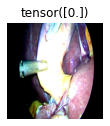

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


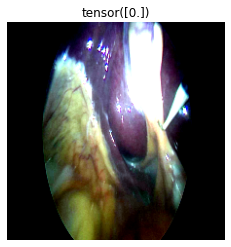

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


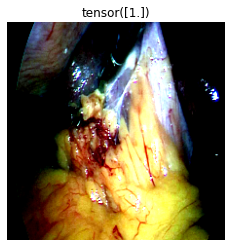

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


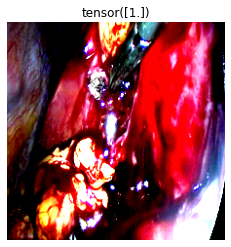

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


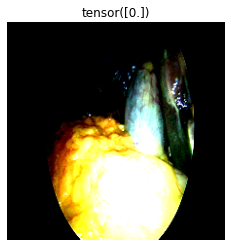

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


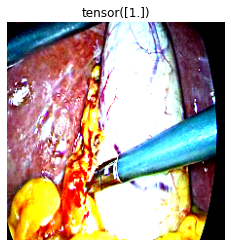

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


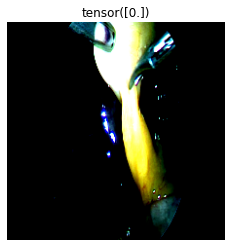

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


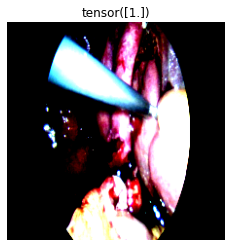

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


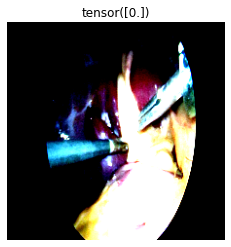

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32, 1])
One Batch Labels: tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.]])


In [6]:
# Print the first sample, as an example (only possible without transform in Dataset)
#sample = lapchol_train.__getitem__(20)
#print(sample)

#print(sample)

# without the transforms applied on the dict: read image from path
#pil_img = Image.open(sample['frame_path']).convert('RGB')
#imshow(np.asarray(pil_img))

#with the transforms applied on the dict: show image
#img, label = lapchol_train.__getitem__(200)
#img = img.numpy().transpose((1, 2, 0))
#imshow(img)
#print(img.shape)

# with the transforms applied on the dict: show multiple images
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    length = lapchol_train.__len__()
    sample_idx = torch.randint(length, size=(1,)).item()
    img, label = lapchol_train.__getitem__(sample_idx)
    img = img.numpy().transpose((1, 2, 0))
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img)
    plt.show()



## Iterate through the Dataloader
# Display image and label.
train_features, train_labels = next(iter(dataloader_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"One Batch Labels: {train_labels}")

#print(train_features)
#print(train_labels)

#train_labels = train_labels.unsqueeze(1)
#print(f"Labels batch shape: {train_labels.size()}")
#img = train_features[0].squeeze()
#label = train_labels[0]
#img = img.numpy().transpose((1, 2, 0))
#plt.imshow(img)
#plt.show()
#print(f"Label: {label}")


#print(lapchol_train.getdict())

In [7]:
# label distribution in train set

#print(lapchol_train.getdict())

total = 0
counter_dict = {0: 0, 1: 0} #2: 0, 3: 0, 4: 0
for i in range(100):
    sample = lapchol_train.__getitem__(i)
    label = sample[1].numpy()
    counter_dict[int(label)] += 1
    total += 1

print(counter_dict)

for i in counter_dict:
    print(f"{i}: {counter_dict[i] / total * 100}")

total_nr_of_samples = lapchol_train.__len__()
print(f' Total number of samples in train set: {total_nr_of_samples}')

{0: 81, 1: 19}
0: 81.0
1: 19.0
 Total number of samples in train set: 10211


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
#for binary classification:
model.fc = torch.nn.Sequential(torch.nn.Linear(num_ftrs, out_features=1,
                                               bias=True), nn.Sigmoid()) #output_features=2? num_ftrs is not the same as 512?
model.to(device)
#print(model)


#for multiple class classification
#model.fc = torch.nn.Sequential(torch.nn.Linear(num_ftrs, out_features=3,
#                                bias=True), torch.nn.Softmax(dim=1))

#for param in model.parameters():
#    param.requires_grad = False   

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# beter goed gejat, dan slecht bedacht 
from ignite.metrics.metric import Metric
from ignite.exceptions import NotComputableError


class BinaryAccuracy(Metric):
    """
    Calculates the binary accuracy.

    - `update` must receive output of the form `(y_pred, y)`.
    - `y_pred` must be in the following shape (batch_size, ...) and it's elements must be between 0 and 1.
    - `y` must be in the following shape (batch_size, ...)
    """
    def reset(self):
        self._num_correct = 0
        self._num_examples = 0

    def update(self, output):
        y_pred, y = output
        correct = torch.eq(torch.round(y_pred).type(y.type()), y).view(-1)
        self._num_correct += torch.sum(correct).item()
        self._num_examples += correct.shape[0]

    def compute(self):
        if self._num_examples == 0:
            raise NotComputableError('BinaryAccuracy must have at least one example before it can be computed')
        return self._num_correct / self._num_examples

In [10]:
optimizer = Adam(model.parameters(), config.learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = torch.nn.BCELoss()
#criterion = torch.nn.CrossEntropyLoss()
epochs = config.epochs

metrics = {'accuracy':BinaryAccuracy(), 'loss':Loss(criterion)} #'accuracy':Accuracy(), , 'cm':ConfusionMatrix(num_classes=len(class_labels))
   
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
train_evaluator = create_supervised_evaluator(model, metrics, device=device) 
val_evaluator = create_supervised_evaluator(model, metrics, device=device)    

log_interval =5


#from ignite.utils import setup_logger
#trainer.logger = setup_logger("Train Logger")
  
#training_history = {'accuracy':[],'loss':[]}
#validation_history = {'accuracy':[],'loss':[]}

#desc = "ITERATION - loss: {:.2f}"
#pbar = tqdm(initial=0, leave=False, total=len(loader), desc=desc.format(0))

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    epoch = engine.state.epoch
    max_batches = engine.state.epoch_length
    batch_nr = engine.state.iteration
    batch_nr = batch_nr - (epoch - 1) * max_batches
    loss = engine.state.output
    wandb.log({"train loss": loss})
    #pbar.desc = desc.format(engine.state.output)
    #pbar.update(log_interval)
    print(f'Epoch[{epoch}] Batch[{batch_nr}/{max_batches}] Loss: {loss:.4f}')
    

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    #pbar.refresh()
    train_evaluator.run(dataloader_train)
    metrics = train_evaluator.state.metrics
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['loss']:.2f}")
    wandb.log({"training loss": metrics['loss']})
    wandb.log({"training accuracy": metrics['accuracy']})


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    val_evaluator.run(dataloader_val)
    metrics = val_evaluator.state.metrics
    validation_acc = val_evaluator.state.metrics["accuracy"]
    print("Epoch: {} Validation accuracy: {:.2f}".format(trainer.state.epoch, validation_acc))
    wandb.log({"validation loss": metrics['loss']})
    wandb.log({"validation accuracy": metrics['accuracy']})
    
    '''
    Using WandBLogger in ignite is a 2-step modular process: First, you need to create 
    a WandBLogger object. Then it can be attached to any trainer or evaluator to automatically log the metrics. 
    We'll do the following tasks sequentially: 1) Create a WandBLogger object and then
    1) Log training loss - attach to trainer
    2) Log validation loss - attach to evaluator
    3) Log optional Parameters
    4) Watch the model
    '''
#wandb_logger.attach_output_handler(
#trainer,
#event_name=Events.ITERATION_COMPLETED,
#tag="training",
#output_transform=lambda loss: {"loss": loss}
#)
 
#wandb_logger.attach_output_handler(
#val_evaluator,
#event_name=Events.EPOCH_COMPLETED,
#tag="validation",
#metric_names=["loss", "accuracy"],
#global_step_transform=lambda *_: trainer.state.iteration,
#)
 
#wandb_logger.attach_opt_params_handler(
#trainer,
#event_name=Events.ITERATION_STARTED,
#optimizer=optimizer,
#param_name='lr'  # optional
#)
 



In [11]:
wandb.watch(model,criterion,log=all,log_freq=10)

In [12]:
trainer.run(dataloader_train, max_epochs=epochs)

Epoch[1] Batch[5/320] Loss: 0.5034
Epoch[1] Batch[10/320] Loss: 0.2915
Epoch[1] Batch[15/320] Loss: 0.2226
Epoch[1] Batch[20/320] Loss: 0.2652
Epoch[1] Batch[25/320] Loss: 0.1837
Epoch[1] Batch[30/320] Loss: 0.1529
Epoch[1] Batch[35/320] Loss: 0.1367
Epoch[1] Batch[40/320] Loss: 0.1145
Epoch[1] Batch[45/320] Loss: 0.1088
Epoch[1] Batch[50/320] Loss: 0.1654
Epoch[1] Batch[55/320] Loss: 0.1748
Epoch[1] Batch[60/320] Loss: 0.1743
Epoch[1] Batch[65/320] Loss: 0.0863
Epoch[1] Batch[70/320] Loss: 0.0614
Epoch[1] Batch[75/320] Loss: 0.0443
Epoch[1] Batch[80/320] Loss: 0.0359
Epoch[1] Batch[85/320] Loss: 0.0459
Epoch[1] Batch[90/320] Loss: 0.0894
Epoch[1] Batch[95/320] Loss: 0.0809
Epoch[1] Batch[100/320] Loss: 0.0916
Epoch[1] Batch[105/320] Loss: 0.0779
Epoch[1] Batch[110/320] Loss: 0.1624
Epoch[1] Batch[115/320] Loss: 0.1455
Epoch[1] Batch[120/320] Loss: 0.0317
Epoch[1] Batch[125/320] Loss: 0.0158
Epoch[1] Batch[130/320] Loss: 0.0159
Epoch[1] Batch[135/320] Loss: 0.0355
Epoch[1] Batch[140/32

wandb: Network error resolved after 0:25:14.406541, resuming normal operation.


Training Results - Epoch[2] Avg accuracy: 1.00 Avg loss: 0.01
Epoch: 2 Validation accuracy: 0.74
Epoch[3] Batch[5/320] Loss: 0.0028
Epoch[3] Batch[10/320] Loss: 0.0587
Epoch[3] Batch[15/320] Loss: 0.0027
Epoch[3] Batch[20/320] Loss: 0.0023
Epoch[3] Batch[25/320] Loss: 0.0158
Epoch[3] Batch[30/320] Loss: 0.0019
Epoch[3] Batch[35/320] Loss: 0.0097
Epoch[3] Batch[40/320] Loss: 0.1760
Epoch[3] Batch[45/320] Loss: 0.0045
Epoch[3] Batch[50/320] Loss: 0.0009
Epoch[3] Batch[55/320] Loss: 0.0010
Epoch[3] Batch[60/320] Loss: 0.0017
Epoch[3] Batch[65/320] Loss: 0.0015
Epoch[3] Batch[70/320] Loss: 0.0006
Epoch[3] Batch[75/320] Loss: 0.0005
Epoch[3] Batch[80/320] Loss: 0.0015
Epoch[3] Batch[85/320] Loss: 0.0026
Epoch[3] Batch[90/320] Loss: 0.0017
Epoch[3] Batch[95/320] Loss: 0.0008
Epoch[3] Batch[100/320] Loss: 0.0056
Epoch[3] Batch[105/320] Loss: 0.0014
Epoch[3] Batch[110/320] Loss: 0.0012
Epoch[3] Batch[115/320] Loss: 0.0028
Epoch[3] Batch[120/320] Loss: 0.0028
Epoch[3] Batch[125/320] Loss: 0.003

Engine run is terminating due to exception: 


KeyboardInterrupt: 

In [ ]:
#torch.save(model(), 'workspace/Lapchol_dataset')